In [11]:
# critical
import argparse
import os
import random
import time
import math

# machine learning
from sklearn.decomposition import PCA

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [12]:
# set random seed for reproducibility
manualSeed = 99
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  99


In [13]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 256

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
# num_epochs = int(32 * (6000/1684))
# num_epochs = 32
num_epochs = 128

# Learning rate for optimizers
lr_g = 0.00002
lr_d = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

In [14]:
class GWDataset(Dataset):
    def __init__(self, signals_csv, parameters_csv):
        ### read data from csv files
        parameters = pd.read_csv(parameters_csv)
        self.signals = pd.read_csv(signals_csv).astype('float32')
        # remove unusual parameters
        keep_signals_idx = np.array(parameters[parameters['beta1_IC_b'] > 0].index)
        parameters = parameters.iloc[:,:]
        ###

        ### process beta_ic_b parameter
        # ranges = [0, 0.06, 0.17, 1]
        # labels = [0, 1, 2]
        # num_classes = len(labels)
        # y = y['beta1_IC_b']
        # y = pd.cut(y, bins=ranges, labels=labels).astype('int')
        # y = y.values
        # y = np.eye(num_classes)[y]
        # y = np.reshape(y, (y.shape[0], y.shape[1], 1)).astype('float32')
        self.parameters = parameters
        ###

        # drop corresponding signals which have erroneous parameter values
        self.signals = self.signals.iloc[:,keep_signals_idx]
        self.signals = self.signals.values
        self.augmented_signals = np.empty(shape = (256, 0)).astype('float32')

        ### flatten signals and take last 256 timestamps
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.signals.shape[1]):
            signal = self.signals[:, i]
            signal = signal.reshape(1, -1)

            cut_signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]
            temp_data = np.insert(temp_data, temp_data.shape[1], cut_signal, axis=1)

        self.signals = temp_data
        ###

    ### augmentation methods ###
    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal
    
    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 50, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.5, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  np.random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 53

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    ### critical functions ###
    def calc_stats(self):
        self.mean = self.signals.mean()
        print('Signal Dataset mean: ',  self.mean)
        self.std = np.std(self.signals, axis=None)
        print('Signal Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Signal Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)
        self.max_value = abs(self.signals).max()
        print('Signal Dataset max value: ',  self.max_value)

    def get_common(self):
        self.common_ylim_signal = (self.signals[:,:].min(), self.signals[:,:].max())
        return self.common_ylim_signal
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal
    
    def normalise(self, signal):
        signal_normalised = signal / self.max_value
        return signal_normalised

    def augmentation(self, desired_augmented_data_count):
        while self.signals.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.signals.shape[1])
            signal_1 = self.signals[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            ### mixture augmentation only ###
            # find the class of signal_1 (assuming class is a column in self.parameters)
            beta_class_of_signal_1 = np.argmax(self.parameters[idx_1, :])
            # sample only from the same class for signal_2 and make sure it's not the same as signal_1
            candidate_indices = [x for x in range(0, 1764) if x != idx_1 and np.argmax(self.parameters[x, :]) == beta_class_of_signal_1]
            idx_2 = np.random.choice(candidate_indices)
            signal_2 = self.signals[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            # augmented_signal = self.window_warping_augmentation(signal_1)
            augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.signals = np.insert(self.signals, self.signals.shape[1], augmented_signal, axis=1)

            # just copy parameters for now
            augmented_parameter = self.parameters[idx_1, :]

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print("Signal Dataset Size after Data Augmentation: ", self.signals.shape)
        print("Parameter Dataset Size after Data Augmentation: ", self.parameters.shape)

    ### overloads ###
    def __len__(self):
        return self.signals.shape[1]

    def __getitem__(self, idx):
        signal = self.signals[:, idx]
        signal = signal.reshape(1, -1)

        # signal_standardized = self.standardize(signal)
        signal_normalised = self.normalise(signal)

        return signal_normalised

In [15]:
def plot_waveforms_standardised(real_signals_batch):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y, color='blue')

        ax.axvline(x=53, color='black', linestyle='--', alpha=0.5)
        ax.grid(True)
        ax.set_ylim((-4, 2))
        
        # Add axis titles
        ax.set_ylabel('distance * strain (cm^2)')
        ax.set_xlabel('n (timestamps)')

        # parameters = real_parameter_batch[i, :].numpy()[0]

        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(407, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    # plt.savefig('../plots/signal-manipulation/gw_signals_standardised_cut.png')
    plt.show()

def plot_waveforms(real_signals_batch):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.plot(x, y, color='blue')

        ax.axvline(x=53, color='black', linestyle='--', alpha=0.5)
        ax.grid(True)
        ax.set_ylim(ylim_signal)
        
        # Add axis titles
        ax.set_ylabel('distance * strain (cm^2)')
        ax.set_xlabel('n (timestamps)')

        # Get parameter values as a NumPy array
        # parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(407, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    # plt.savefig('../plots/signal-manipulation/gw_signals_cut.png')
    plt.show()

Signal Dataset mean:  -0.51635957
Signal Dataset std:  39.724163
Signal Dataset scaling factor (to match noise in generator):  5
Signal Dataset max value:  656.2575
Signal Batch Size:  torch.Size([32, 1, 256])


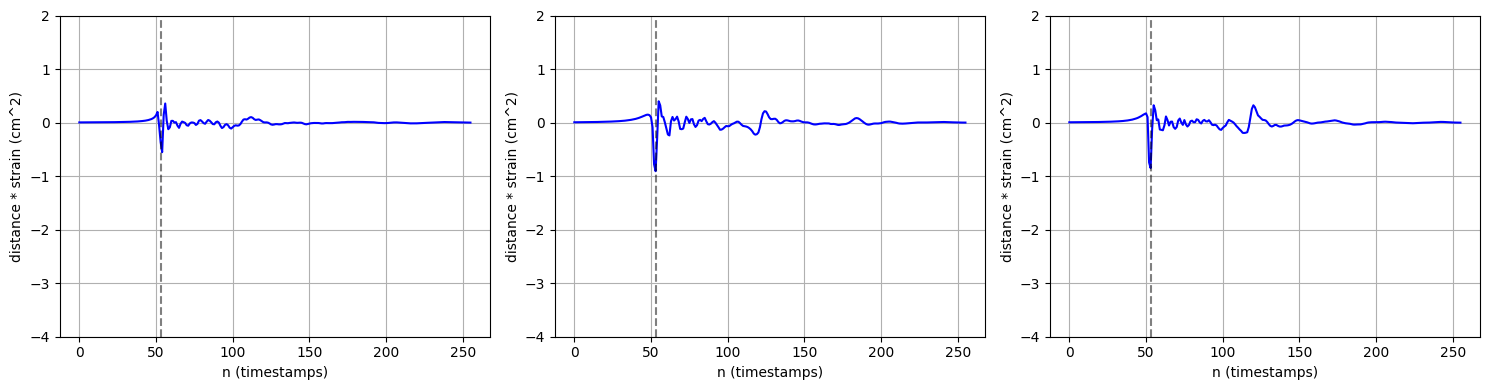

In [16]:
dataset = GWDataset("../data/input/richers_1764.csv", "../data/input/richers_1764_parameters.csv")

ylim_signal = dataset.get_common()
# dataset.augmentation(6000)
dataset.calc_stats()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_signals_batch  = next(iter(dataloader))

print("Signal Batch Size: ", real_signals_batch.shape)

ylim_signal_standardised = dataset.get_common()

plot_waveforms_standardised(real_signals_batch)
# plot_waveforms_standardised(real_signals_batch, real_parameter_batch)

In [17]:
dataset.__len__()

1684

### Weight Initialisation (Random Noise)

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [19]:
if gans_type == 'dcgans':
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
                nn.Tanh()
            )

        def forward(self, z):
            z = self.main(z)
            return z
        
if gans_type == 'gans':
    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(nz, ngf),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf, ngf * 2),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 2, ngf * 4),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 4, ngf * 8),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 8, 512),
            )

        def forward(self, z):
            z = z.view(z.size(0), -1)  # Flatten the tensor
            z = self.main(z)
            z = z.view(z.size(0), 1, 512)
            return z

In [20]:
netG = Generator().to(device)

netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, nc))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(256, 2048, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias

### Discriminator

In [21]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                ### Can increase model complexity here ###
                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "gans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(256, 128),
                # nn.BatchNorm1d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(128, 64),
                # nn.BatchNorm1d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(64, 32),
                # nn.BatchNorm1d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(32, 16),
                # nn.BatchNorm1d(16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(16, 1),
                nn.Sigmoid(),
            )

        def forward(self, x):
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = self.main(x)
            return x

In [22]:
netD = Discriminator().to(device)

netD.apply(weights_init)

print(netD)

model = Discriminator()
summary(model, input_size=(nc, 256))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2,

/Users/tarineccleston/Documents/software-ds/gw-generative-models/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Loss functions and Optimisers

In [23]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# learning-rate decay scheduler
schedulerD = lr_scheduler.LinearLR(optimizerD, start_factor=1.0, end_factor=0.5, total_iters=32)
schedulerG = lr_scheduler.LinearLR(optimizerG, start_factor=1.0, end_factor=0.5, total_iters=32)

# establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

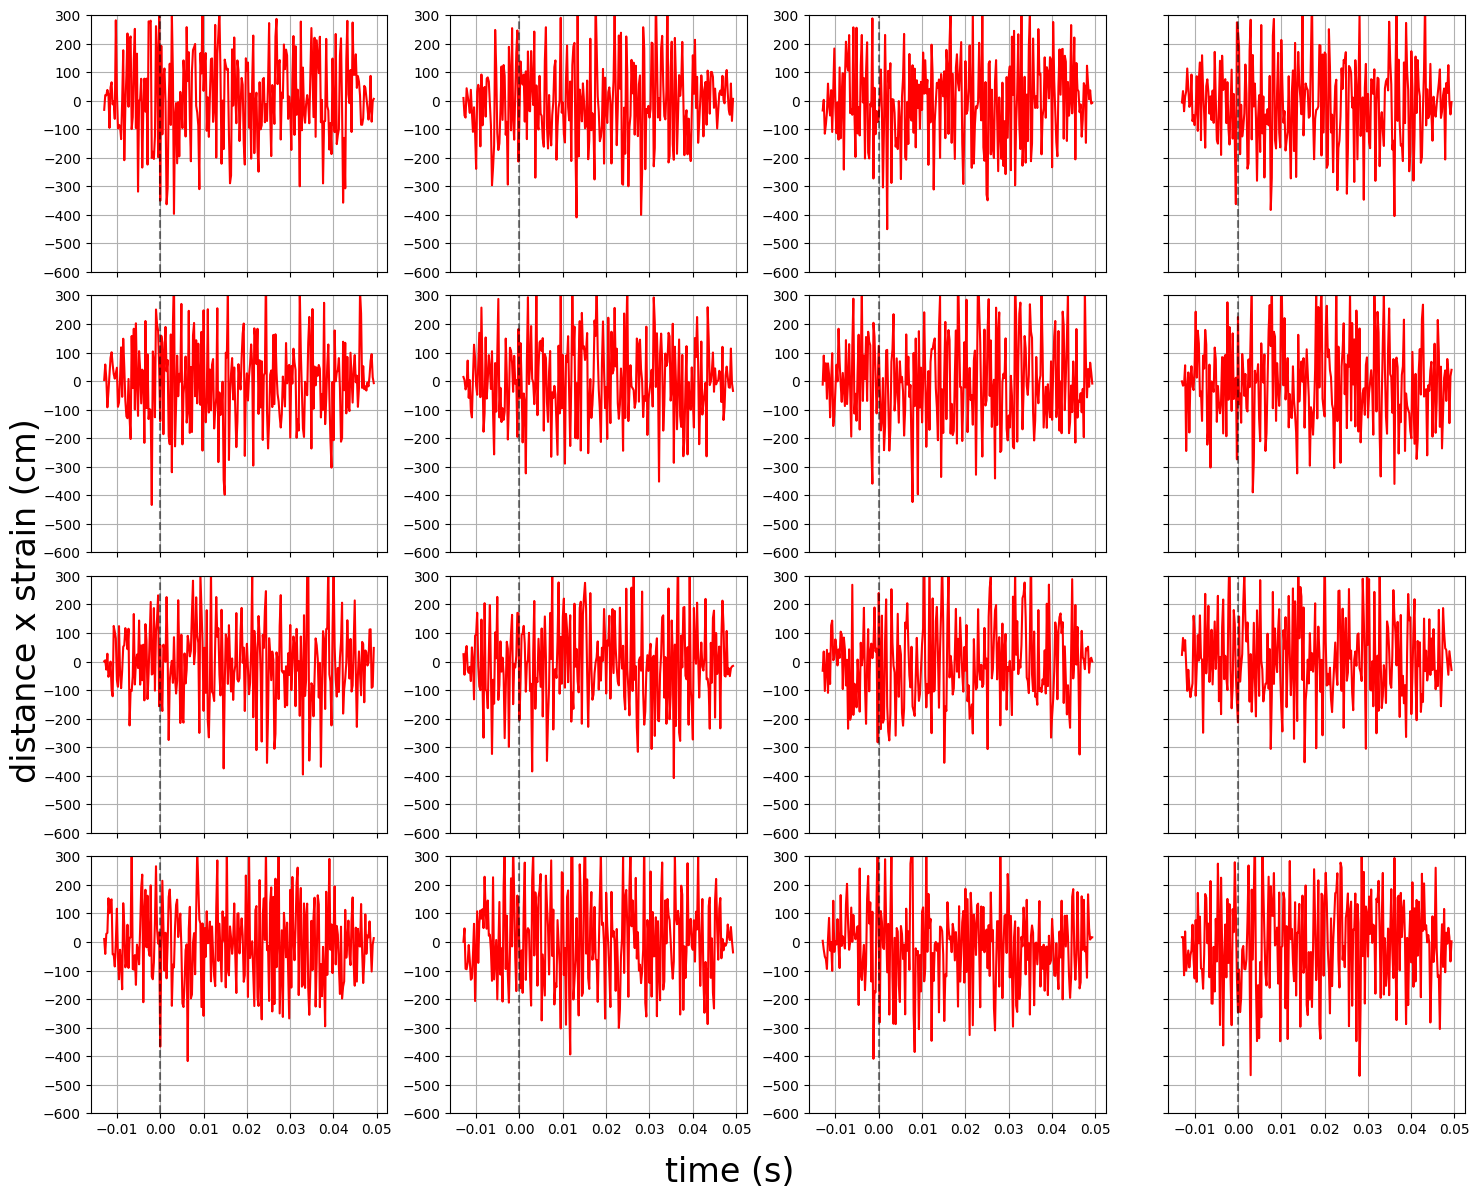

In [24]:
# create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)
# fixed_noise = torch.distributions.cauchy.Cauchy(0, 1).sample((batch_size, nz, 1)).to(device)

num_cols = 4
num_rows = 4

# plot generated signals before training
with torch.no_grad():
    fake_signals = netG(fixed_noise).detach().cpu()
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))

    axes = axes.flatten()

    # plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = [i / 4096 for i in range(0, 256)]
        x = [value - (53/4096) for value in x]
        y = fake_signals[i, :, :].flatten()
        y = y * dataset.max_value
        ax.set_ylim(-600, 300)
        ax.plot(x, y, color='red')

        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax.grid(True)
        
        # Remove y-axis ticks for the right-hand column
        if i % num_cols == num_cols - 1:
            ax.yaxis.set_ticklabels([])
        
        # Remove x-axis tick labels for all but the bottom two plots
        if i <= 11:
            ax.xaxis.set_ticklabels([])

    for i in range(512, 8*4):
        fig.delaxes(axes[i])

    fig.supxlabel('time (s)', fontsize=24)
    fig.supylabel('distance x strain (cm)', fontsize=24)

    plt.tight_layout()
    plt.show()

### Training

Starting Training Loop...
[0/128][0/53]	Loss_D: 1.6477	Loss_G: 0.7836	D(x): 0.3831	D(G(z)): 0.4614 / 0.4704
[0/128][50/53]	Loss_D: 0.6612	Loss_G: 1.2653	D(x): 0.8364	D(G(z)): 0.3030 / 0.2930
Epoch 0: SGD Discriminator lr 0.0000200 -> 0.0000197
Epoch 0: SGD Generator lr 0.0000200 -> 0.0000197


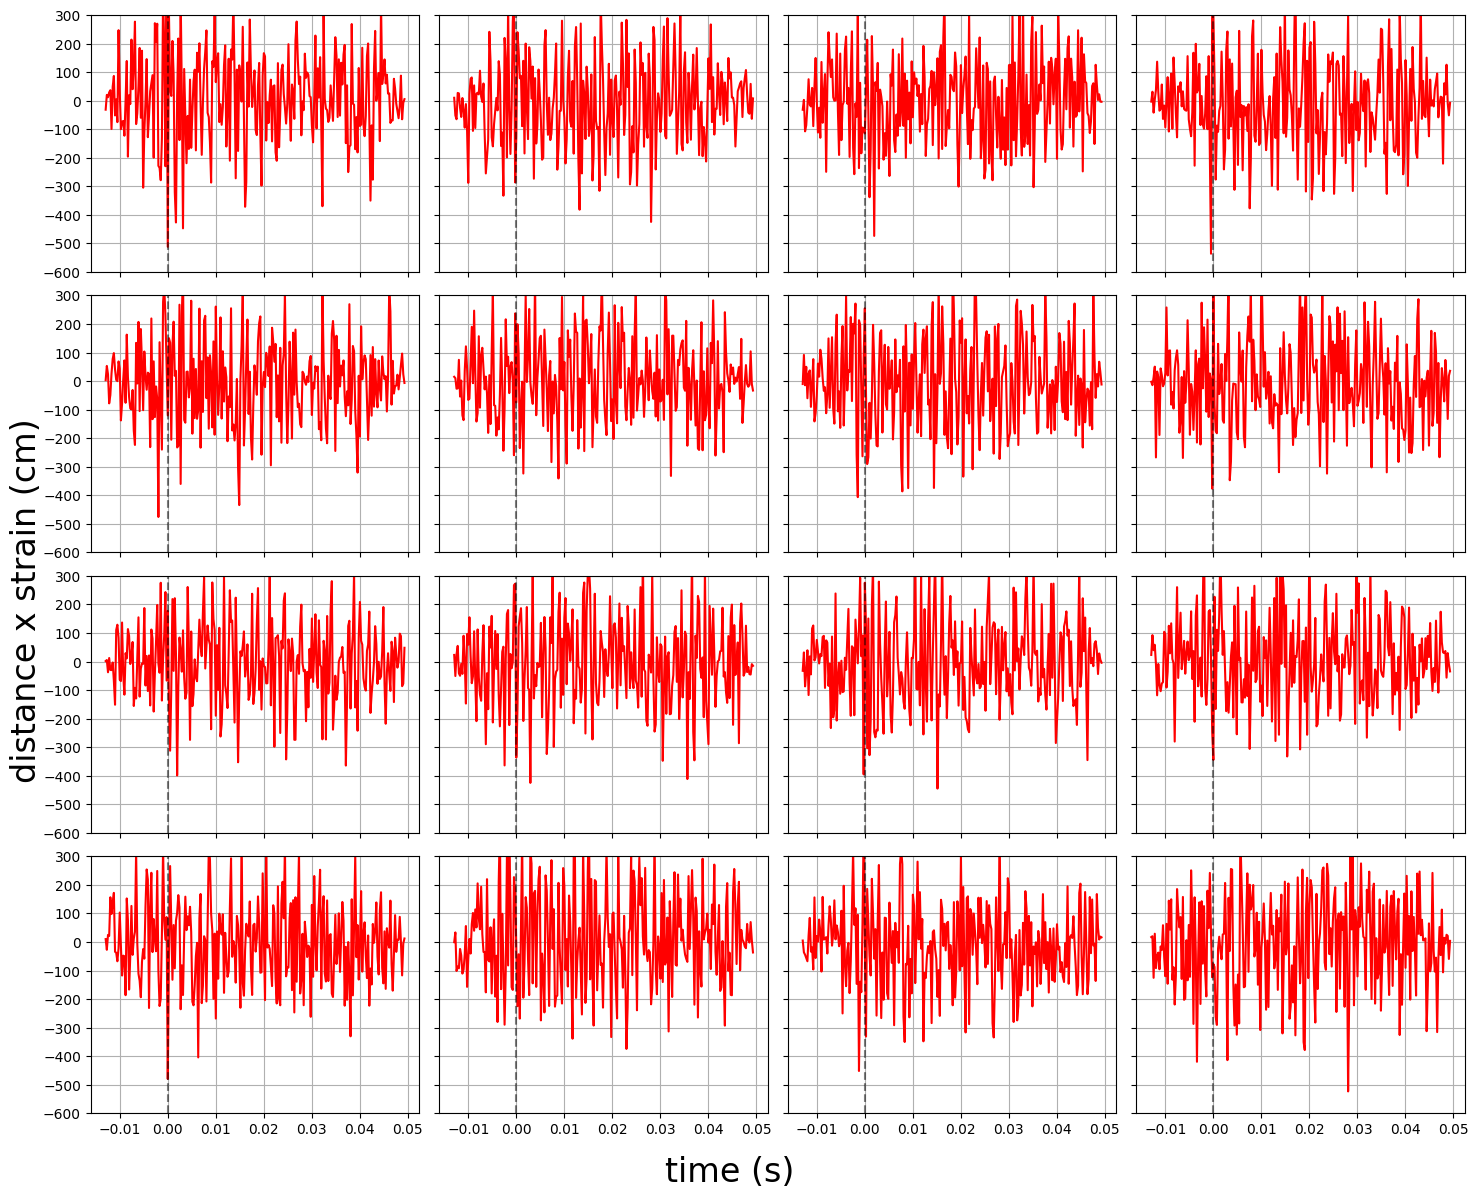

[1/128][0/53]	Loss_D: 0.7142	Loss_G: 1.2473	D(x): 0.8070	D(G(z)): 0.3051 / 0.3030
[1/128][50/53]	Loss_D: 0.6539	Loss_G: 1.6448	D(x): 0.8286	D(G(z)): 0.2014 / 0.2143
Epoch 1: SGD Discriminator lr 0.0000197 -> 0.0000194
Epoch 1: SGD Generator lr 0.0000197 -> 0.0000194


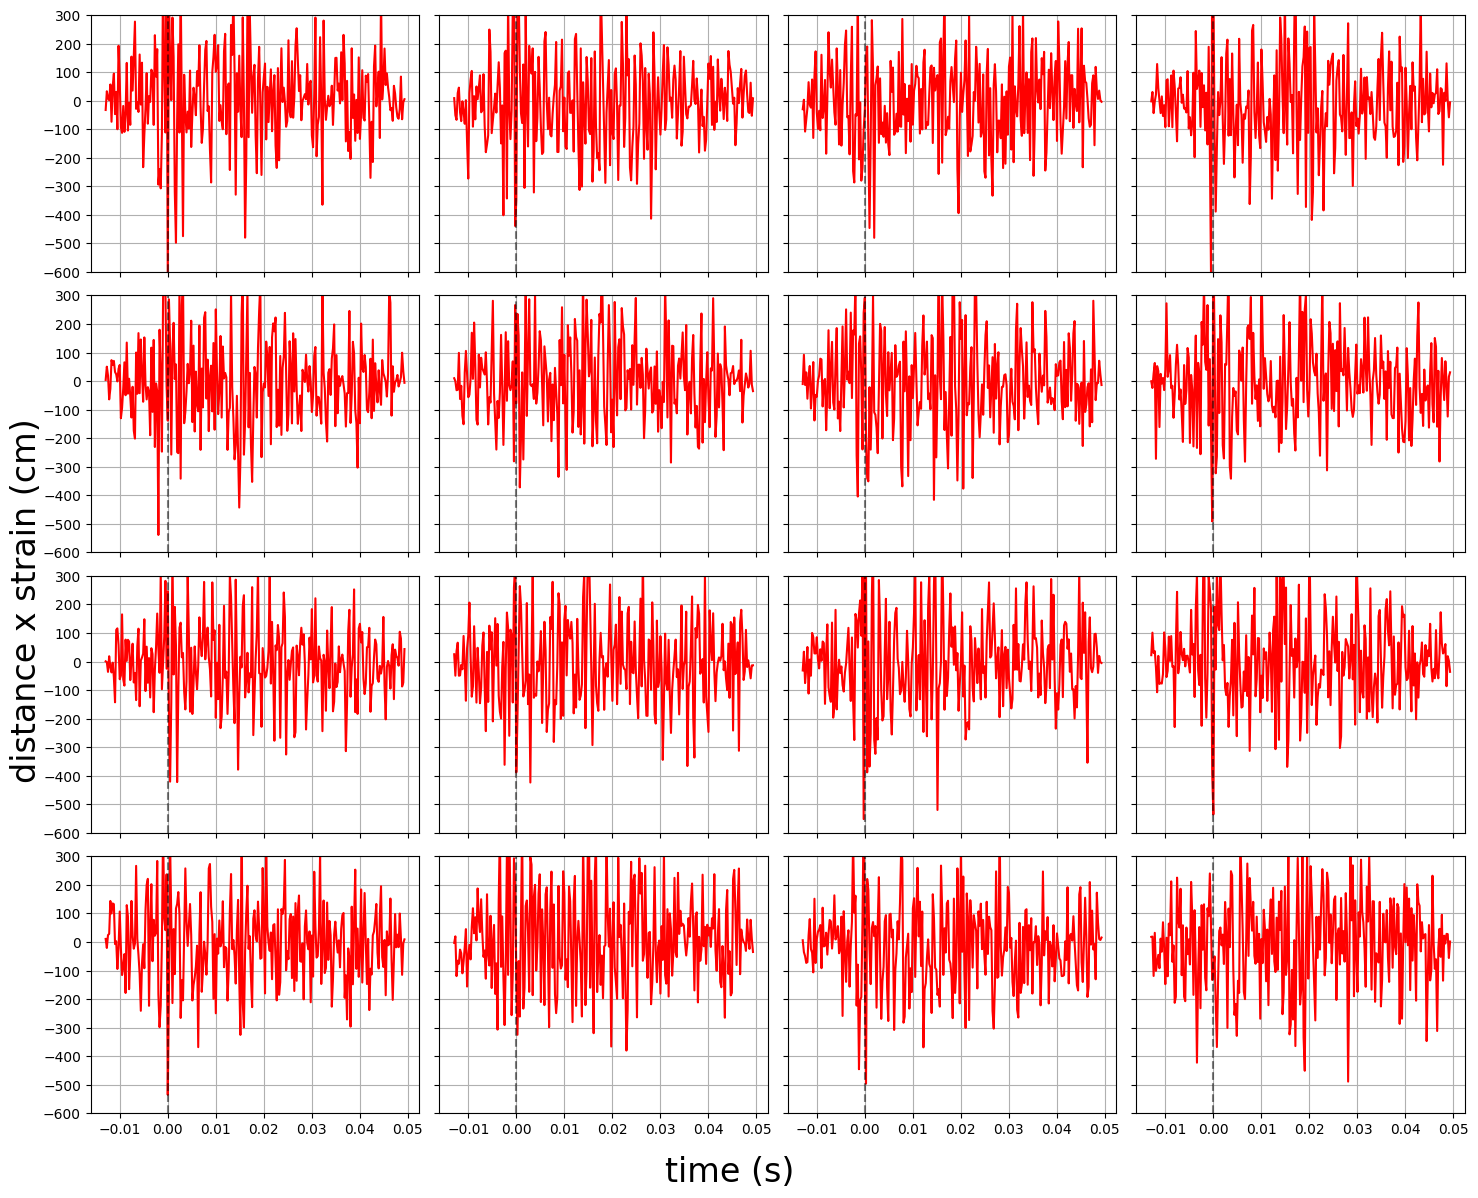

[2/128][0/53]	Loss_D: 0.5617	Loss_G: 1.5513	D(x): 0.9086	D(G(z)): 0.2549 / 0.2368
[2/128][50/53]	Loss_D: 0.5382	Loss_G: 1.6282	D(x): 0.8674	D(G(z)): 0.1996 / 0.2085
Epoch 2: SGD Discriminator lr 0.0000194 -> 0.0000191
Epoch 2: SGD Generator lr 0.0000194 -> 0.0000191


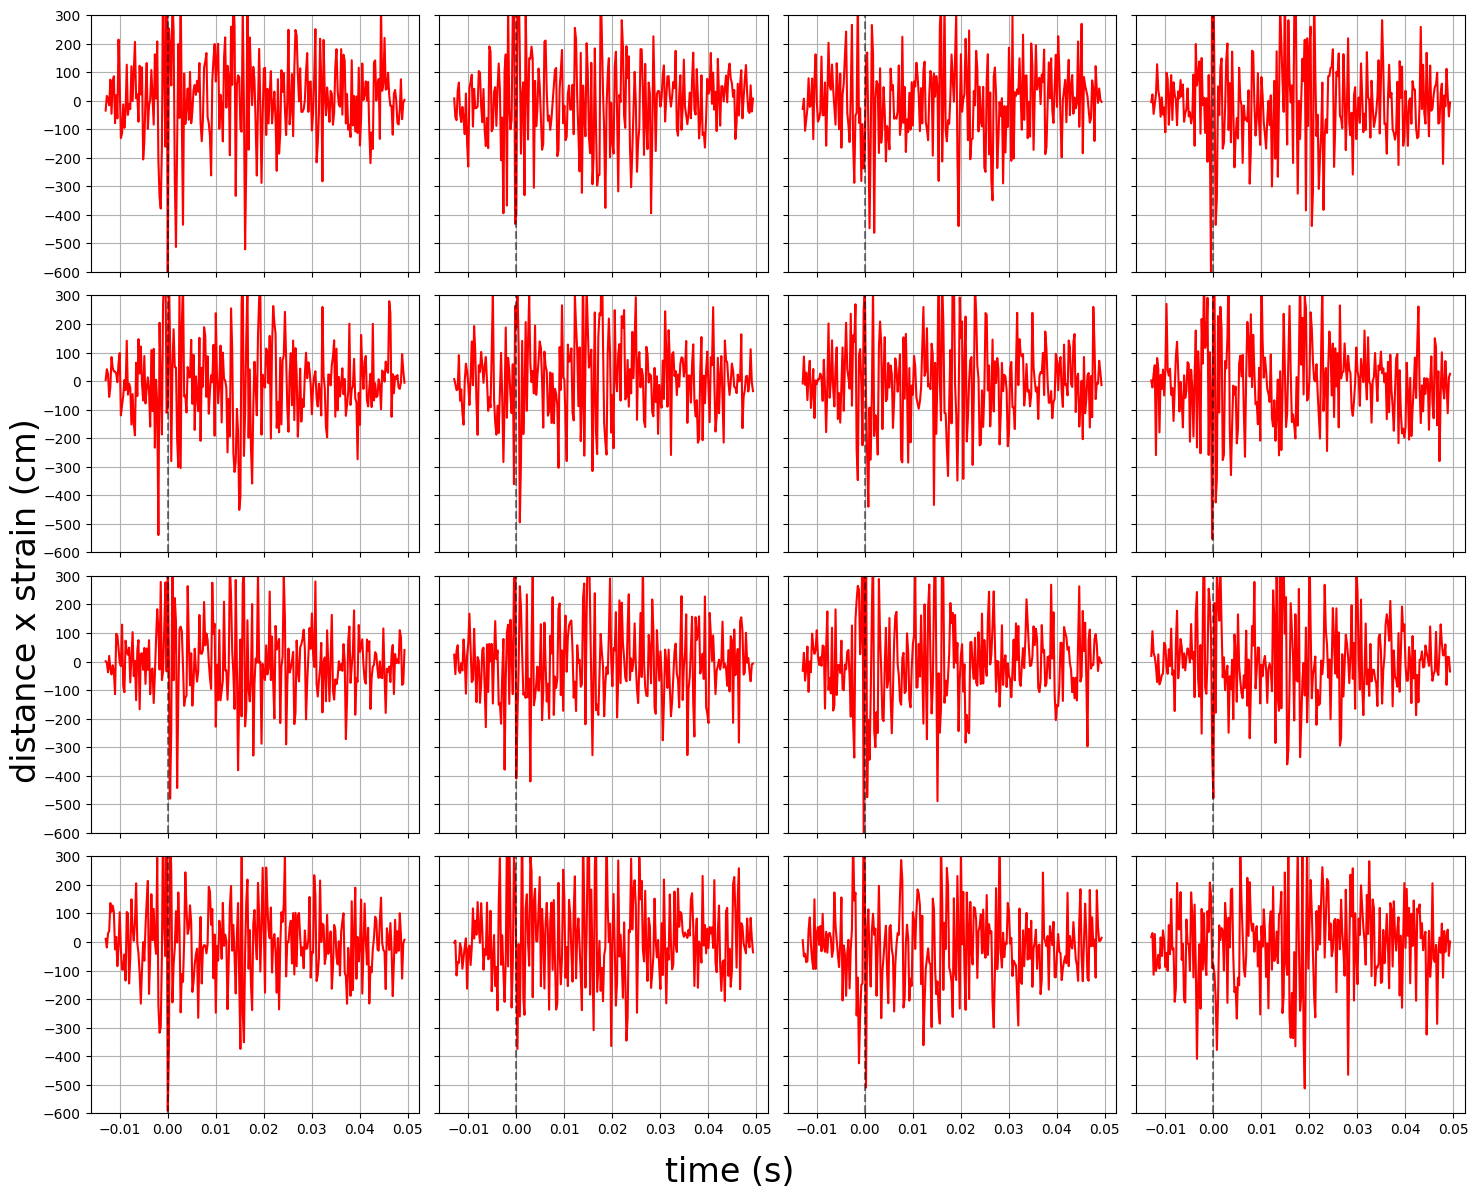

[3/128][0/53]	Loss_D: 0.5142	Loss_G: 1.7371	D(x): 0.9267	D(G(z)): 0.2189 / 0.2035
[3/128][50/53]	Loss_D: 0.5386	Loss_G: 1.9207	D(x): 0.9109	D(G(z)): 0.1903 / 0.1706
Epoch 3: SGD Discriminator lr 0.0000191 -> 0.0000188
Epoch 3: SGD Generator lr 0.0000191 -> 0.0000188


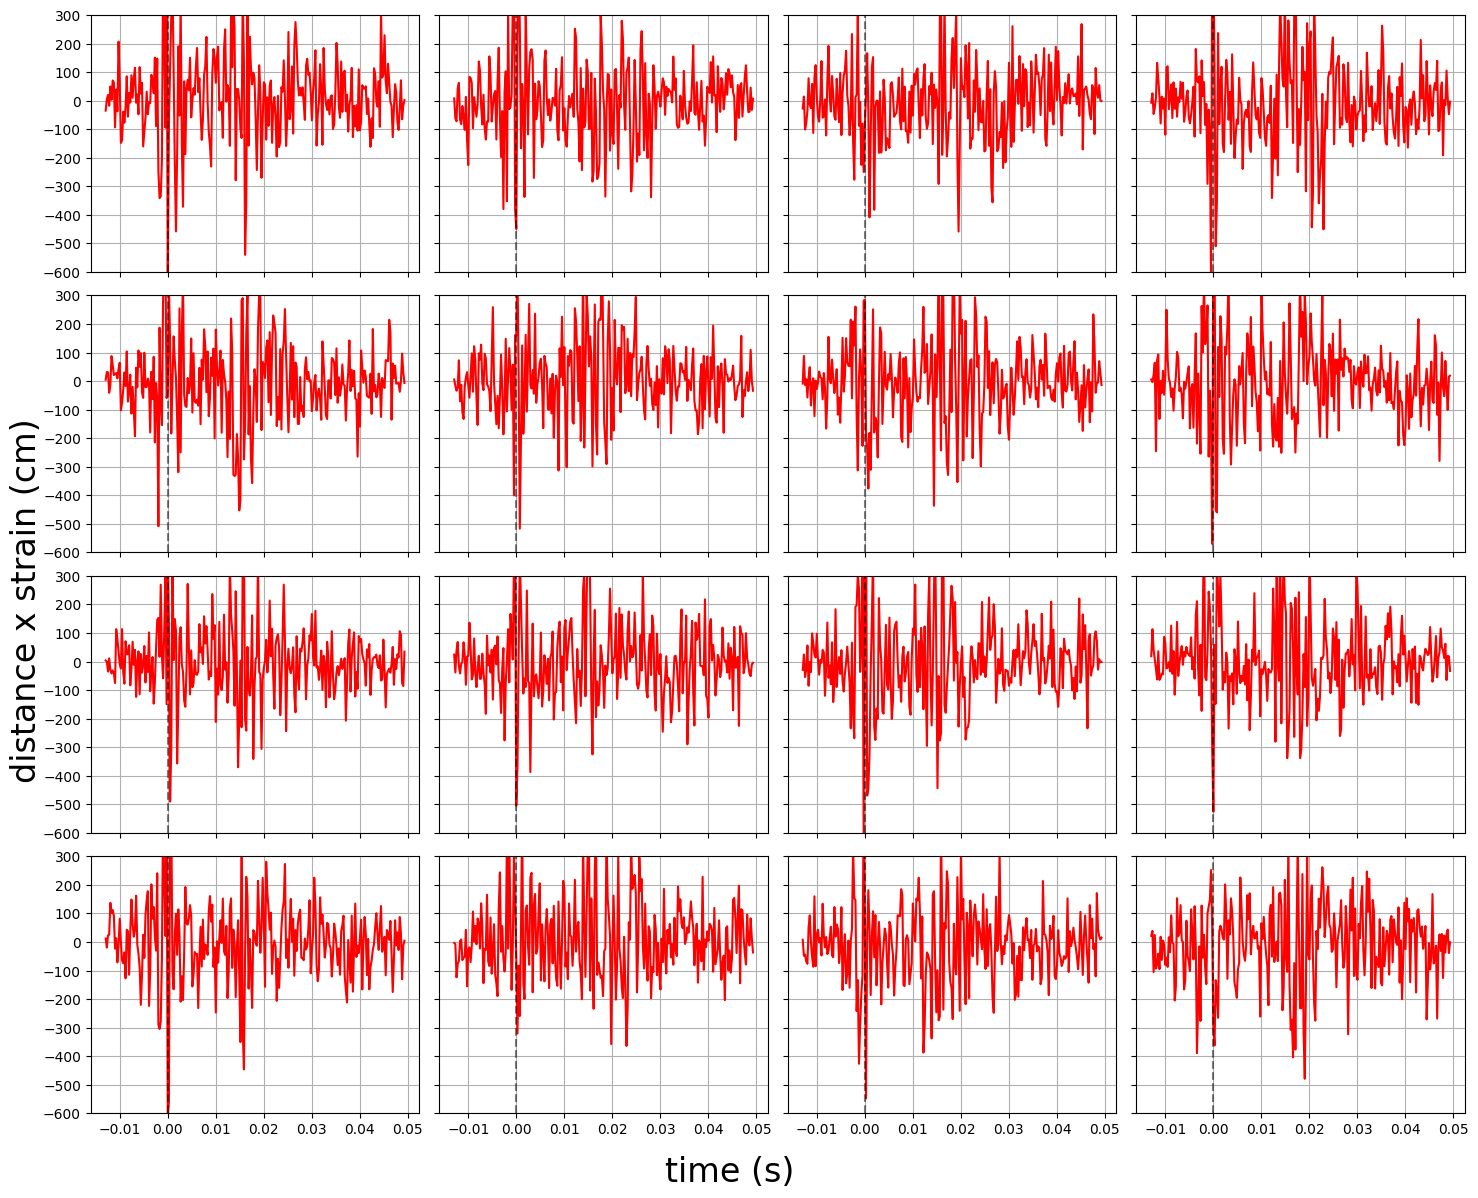

[4/128][0/53]	Loss_D: 0.5228	Loss_G: 1.9345	D(x): 0.9134	D(G(z)): 0.2056 / 0.1685
[4/128][50/53]	Loss_D: 0.5174	Loss_G: 1.9571	D(x): 0.8850	D(G(z)): 0.1662 / 0.1677
Epoch 4: SGD Discriminator lr 0.0000188 -> 0.0000184
Epoch 4: SGD Generator lr 0.0000188 -> 0.0000184


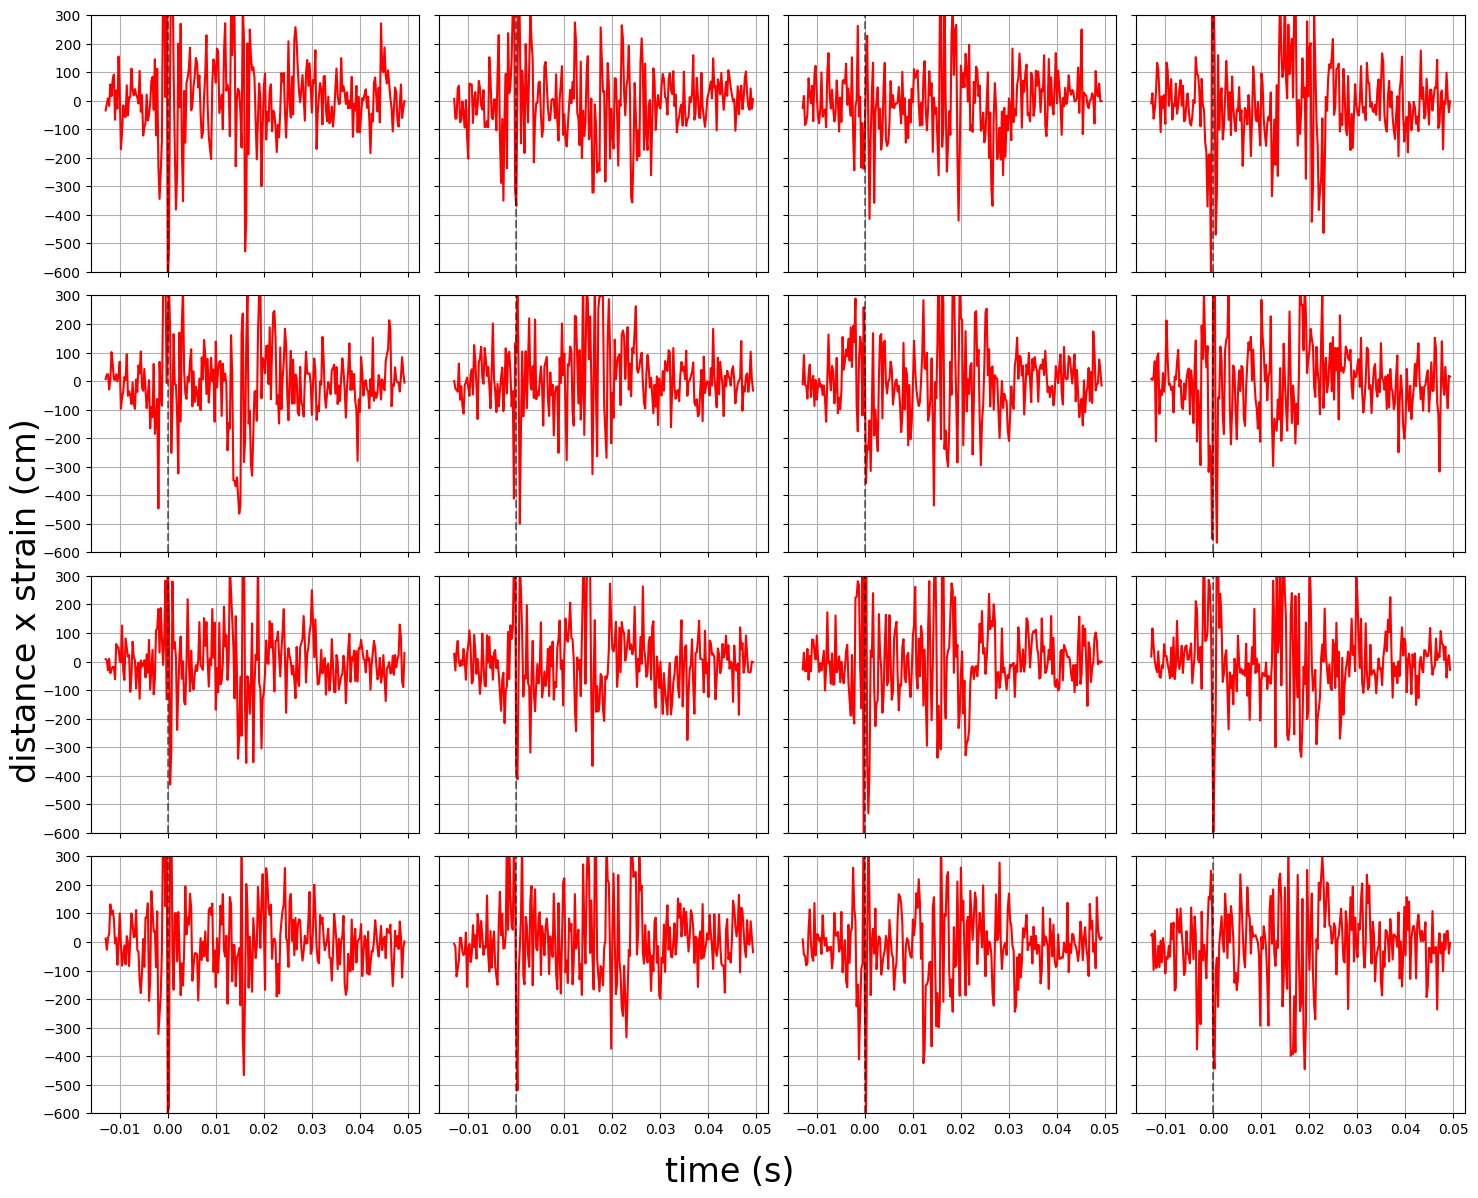

[5/128][0/53]	Loss_D: 0.5088	Loss_G: 2.0054	D(x): 0.9392	D(G(z)): 0.1931 / 0.1678
[5/128][50/53]	Loss_D: 0.5309	Loss_G: 1.9141	D(x): 0.9255	D(G(z)): 0.2341 / 0.1803
Epoch 5: SGD Discriminator lr 0.0000184 -> 0.0000181
Epoch 5: SGD Generator lr 0.0000184 -> 0.0000181


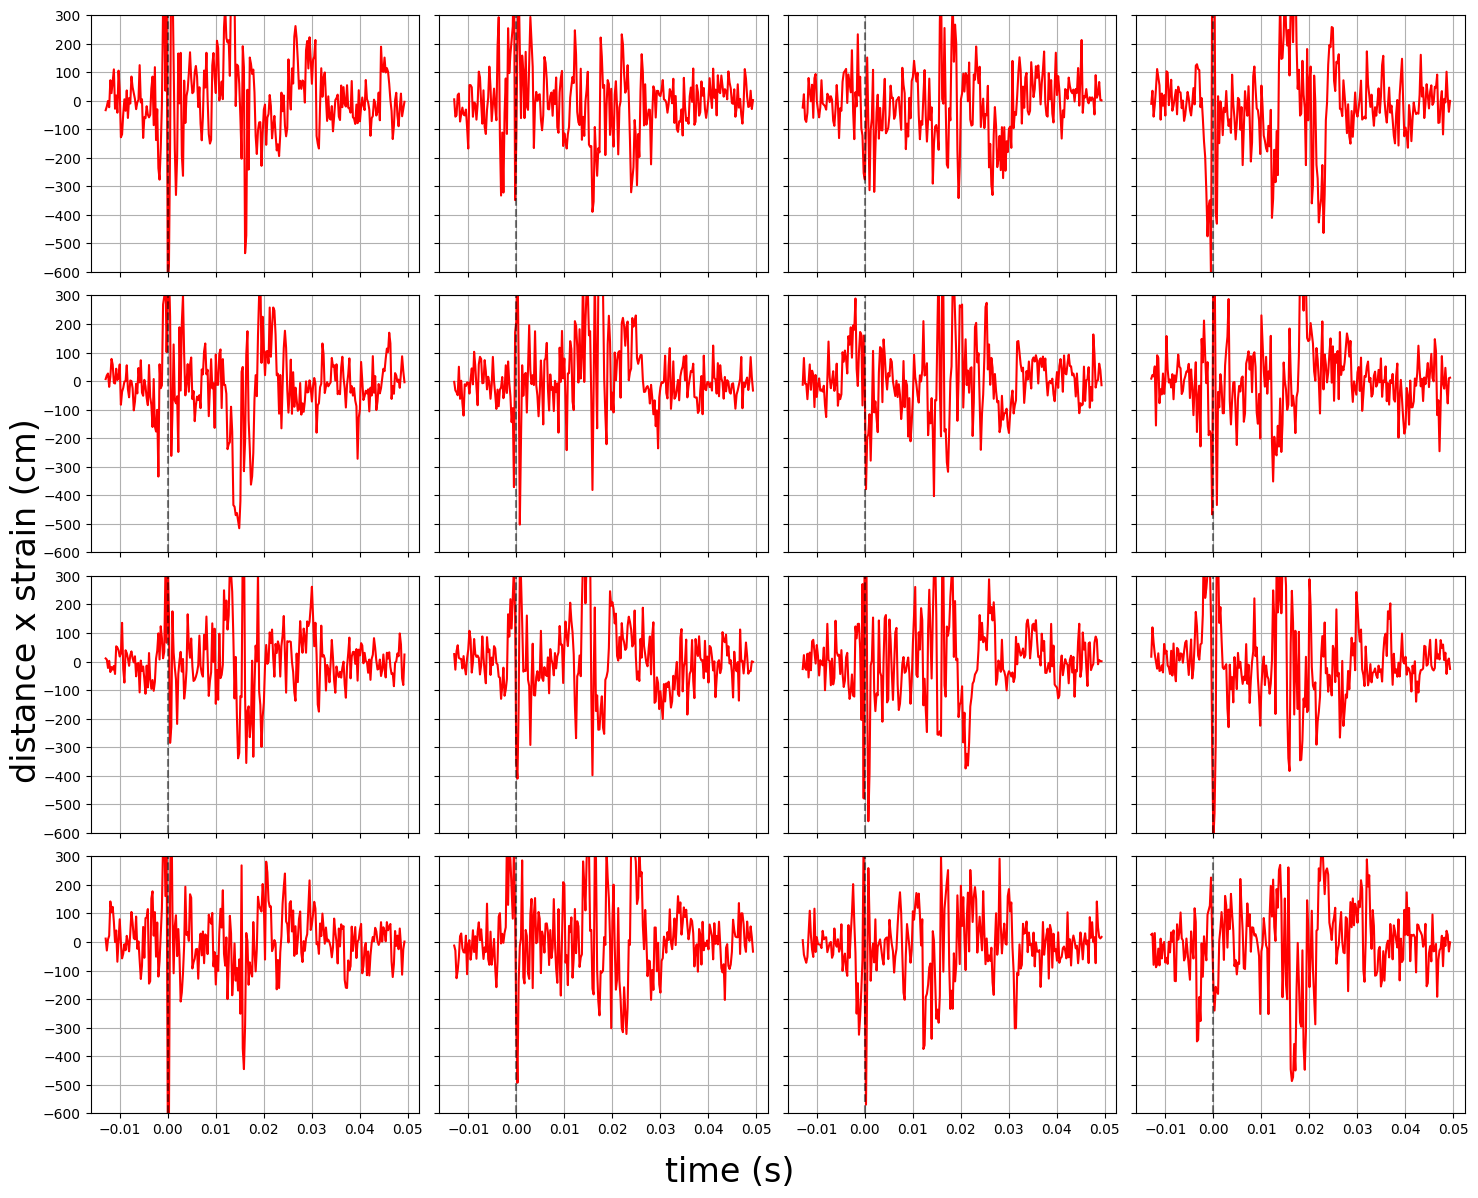

[6/128][0/53]	Loss_D: 0.5261	Loss_G: 1.9407	D(x): 0.9151	D(G(z)): 0.1727 / 0.1701
[6/128][50/53]	Loss_D: 0.5590	Loss_G: 2.2550	D(x): 0.9001	D(G(z)): 0.1505 / 0.1307
Epoch 6: SGD Discriminator lr 0.0000181 -> 0.0000178
Epoch 6: SGD Generator lr 0.0000181 -> 0.0000178


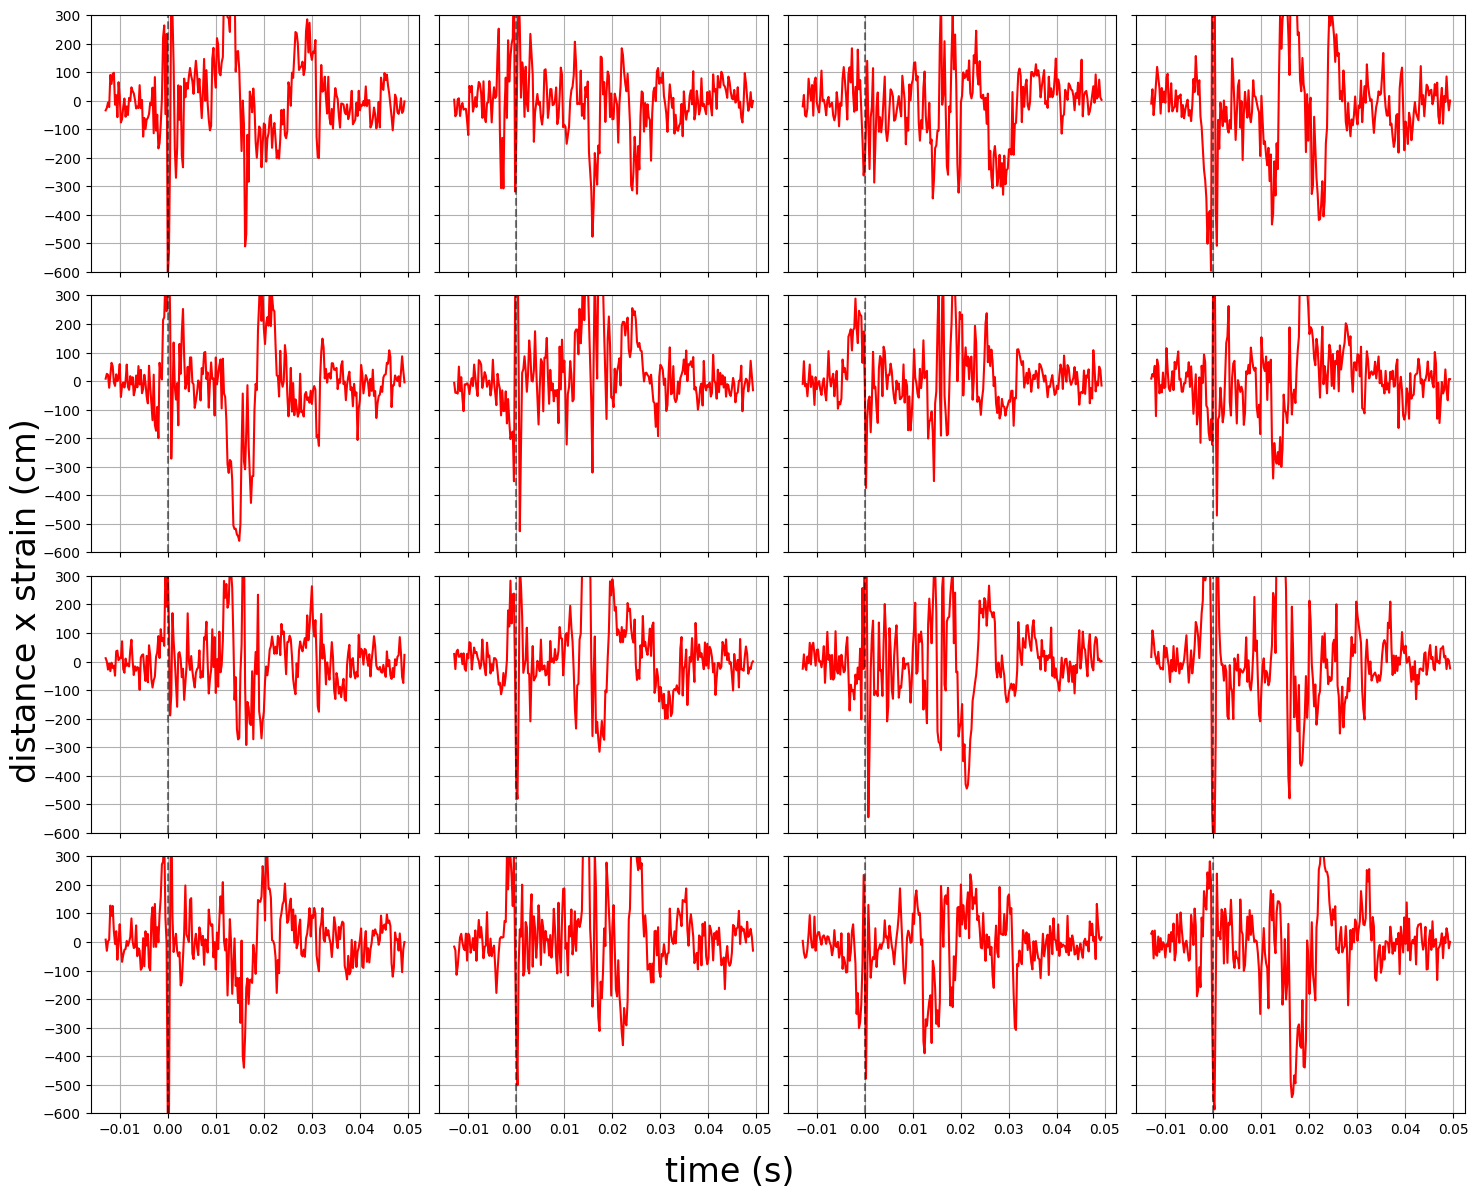

[7/128][0/53]	Loss_D: 0.5751	Loss_G: 1.7137	D(x): 0.8892	D(G(z)): 0.2051 / 0.2264
[7/128][50/53]	Loss_D: 0.5555	Loss_G: 1.6564	D(x): 0.9364	D(G(z)): 0.2292 / 0.2253
Epoch 7: SGD Discriminator lr 0.0000178 -> 0.0000175
Epoch 7: SGD Generator lr 0.0000178 -> 0.0000175


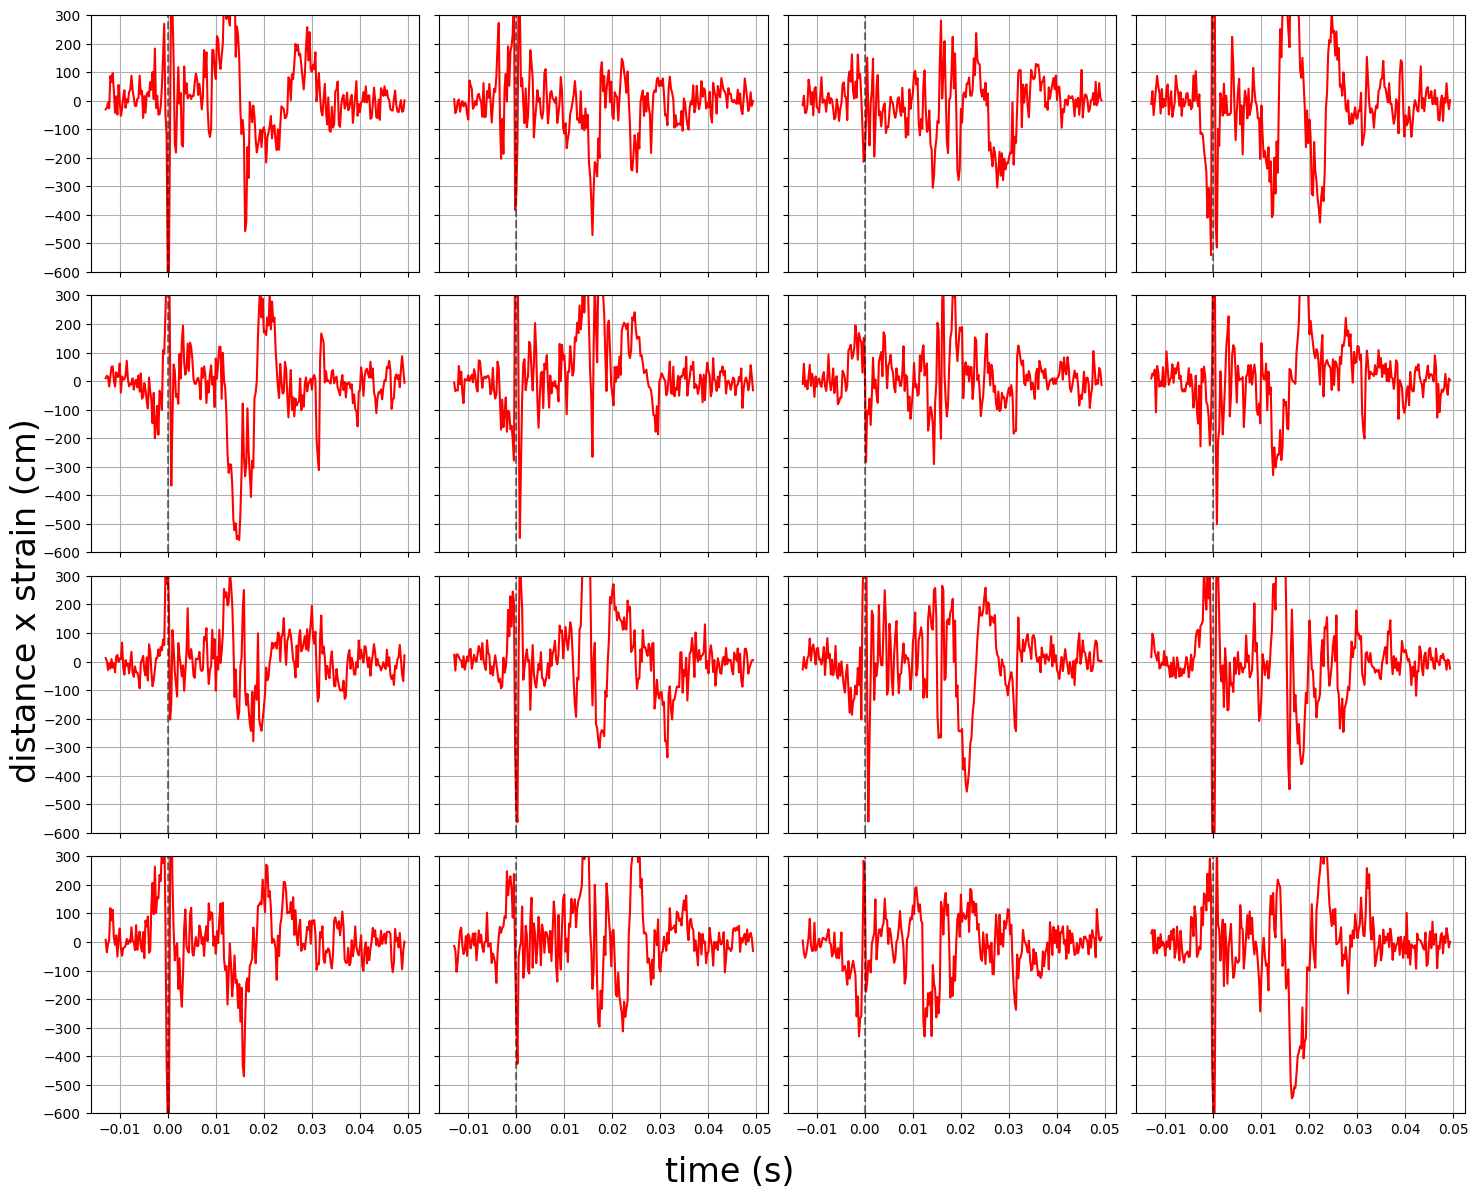

[8/128][0/53]	Loss_D: 0.5746	Loss_G: 1.5821	D(x): 0.8780	D(G(z)): 0.2287 / 0.2557
[8/128][50/53]	Loss_D: 0.5720	Loss_G: 1.8489	D(x): 0.9159	D(G(z)): 0.2095 / 0.2140
Epoch 8: SGD Discriminator lr 0.0000175 -> 0.0000172
Epoch 8: SGD Generator lr 0.0000175 -> 0.0000172


In [25]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

start = time.time()

if (gans_type == 'dcgans' or gans_type == 'gans'):
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_gpu = data.to(device)
            b_size = real_gpu.size(0)
            label_real = torch.FloatTensor(b_size).uniform_(1.0, 1.0).to(device)
            # Forward pass real batch through D
            output = netD(real_gpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label_real)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, device=device)
            # noise = torch.distributions.cauchy.Cauchy(0, 1).sample((b_size, nz, 1)).to(device)
            # Generate fake signal batch with G
            fake = netG(noise)
            label_fake = torch.FloatTensor(b_size).uniform_(0.0, 0.25).to(device)
            # label_fake = torch.FloatTensor(b_size).uniform_(0.0, 0.0).to(device)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label_fake)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
            # Calculate gradients of discriminator parameters
            D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label_real = torch.FloatTensor(b_size).uniform_(1.0, 1.0).to(device)
            # label_real = 1.0 - label_fake
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label_real)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            # Calculate gradients of generator parameters
            G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1 
        
        # learning-rate decay
        before_lr = optimizerD.param_groups[0]["lr"]
        schedulerD.step()
        after_lr = optimizerD.param_groups[0]["lr"]
        print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        before_lr = optimizerG.param_groups[0]["lr"]
        schedulerG.step()
        after_lr = optimizerG.param_groups[0]["lr"]
        print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        # plot generated signals before training
        with torch.no_grad():
            fake_signals = netG(fixed_noise).detach().cpu()
            fig, axes = plt.subplots(4, 4, figsize=(15, 12))

            axes = axes.flatten()

            # plot each signal on a separate subplot
            for i, ax in enumerate(axes):
                x = [i / 4096 for i in range(0, 256)]
                x = [value - (53/4096) for value in x]
                y = fake_signals[i, :, :].flatten()
                # y = y * dataset.scaling_factor
                # y = y * dataset.std + dataset.meanx
                y = y * dataset.max_value
                ax.set_ylim(-600, 300)
                ax.plot(x, y, color='red')

                ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
                ax.grid(True)
                
                # Remove y-axis ticks for the right-hand column
                if i % 4 != 0:
                    ax.yaxis.set_ticklabels([])
                
                if i <= 11:
                    ax.xaxis.set_ticklabels([])

            for i in range(512, 8*4):
                fig.delaxes(axes[i])

            fig.supxlabel('time (s)', fontsize=24)
            fig.supylabel('distance x strain (cm)', fontsize=24)

            plt.tight_layout()
            plt.show()
        
        signal_list.append(fake_signals)

end = time.time()

print("Training Time: ", end - start)

### Gradients

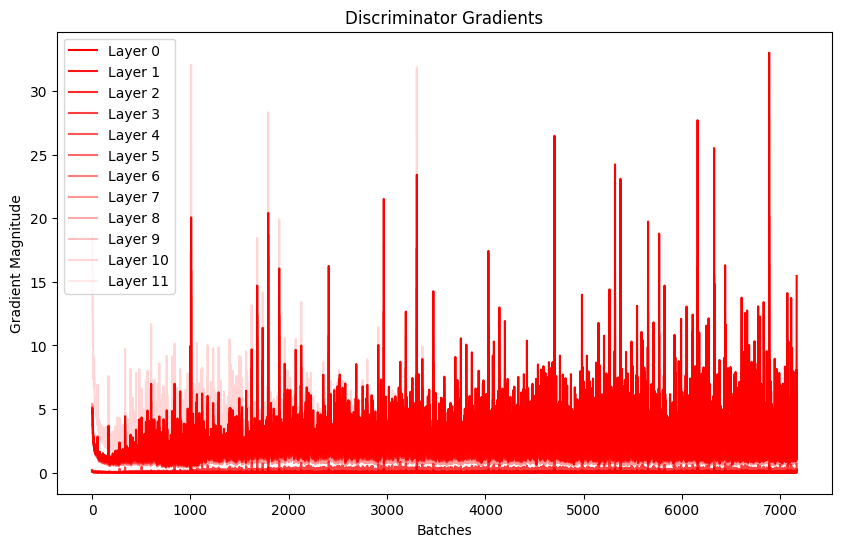

In [ ]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Batches')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
# plt.savefig("../plots/architecture/gw_d_gradients_status_quo_32e.png")
plt.show()

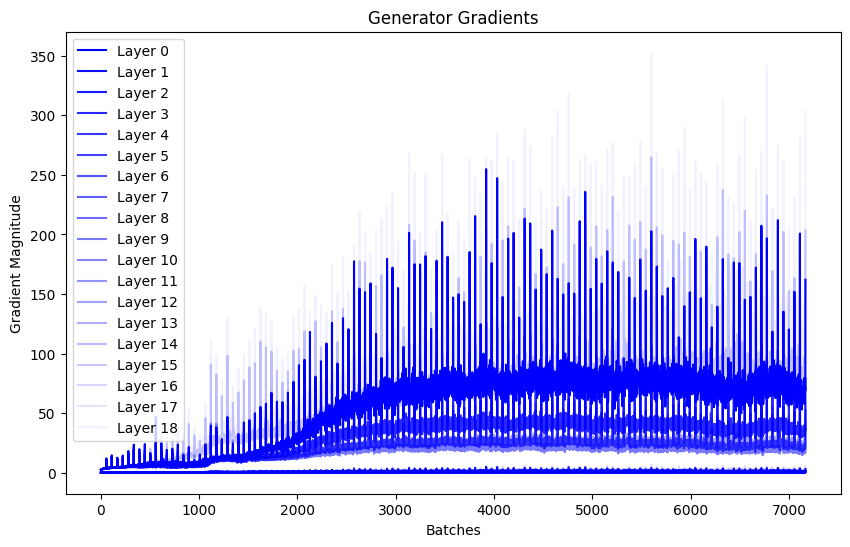

In [ ]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Batches')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
# plt.savefig("../plots/architecture/gw_g_gradients_status_quo_32e.png")
plt.show()

### Loss

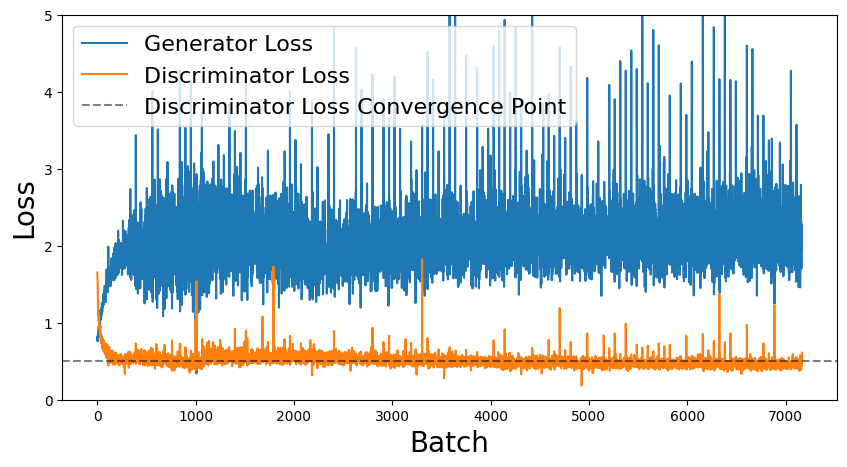

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Discriminator Loss Convergence Point')
plt.xlabel("Batch", size=20)
plt.ylabel("Loss", size=20)
plt.ylim(0, 5)
plt.legend(fontsize=16)
# plt.savefig("../plots/architecture/dcgans_training_loss_128e.pdf")
plt.show()

### Save Generator

In [ ]:
# torch.save(netG, "../models/stellar_core_collapse_signal_generator_dcgans.pt")